This notebook describes the execution of DRNets for Multi-MNIST-Sudoku. 
It is preferable to run on GPUs or it may be quite slow.


The requirements for running the code are:

    Python 3.6
    Pytorch 1.3.1 (any version should work; we suggest this version)
    torchvision
    skimage
    scikit-learn

We first define the functions for generating Multi-MINST-Sudoku instances and download the MNIST datasets automatically.

In [1]:
from collections import defaultdict
import mnist
import random
import numpy as np
import sys
from skimage.transform import resize

def rescale(x):
    x = np.asarray(x)
    x = x.reshape(16, 1, 28, 28)
    x = np.transpose(x, (1, 2, 3, 0))
    x = resize(x, (1, 32, 32, 16))
    x = np.transpose(x, (3, 0, 1, 2))
    for i in range(16):
        x[i][0] = (x[i][0] - 0.5) / 0.5
        
    return x


In [2]:
def gen_data(n, dtype, seed):
    seed = seed
    np.random.seed(seed)
    if ("5" in dtype):
        diff_num = True
    else:
        diff_num = False
        
    sudokus = np.load("all4sudoku.npy")
    if diff_num:
        digit2digit = {1: 5, 2: 6, 3: 7, 4: 8}
        for idx, num in np.ndenumerate(sudokus):
            sudokus[idx] = digit2digit[num]
            
    test_images = mnist.test_images() #mnist.test_images()
    test_labels = mnist.test_labels() #mnist.test_labels()

    digit_map = defaultdict(list)

    for i in range(len(test_labels)):
        digit_map[test_labels[i]].append(test_images[i])

    rtn = []
    rtn_labels = []
    n_iter = n // len(sudokus)+1
    for i in range(n_iter):  
        for sudoku in sudokus:
            flatten = [number for sublist in sudoku for number in sublist]
            rtn_labels.append(flatten)
            mnist_sudoku = []
            for number in flatten:
                rnd = np.random.randint(len(digit_map[number]))
                mnist_sudoku.append(digit_map[number][rnd])

            rtn.append(rescale(mnist_sudoku))

    rtn, rtn_labels = rtn[:n], rtn_labels[:n]
    rtn, rtn_labels = np.array(rtn), np.array(rtn_labels)

    print("generated mixed sudokus' shape: ", rtn.shape)
    print("generated label shape: ", rtn_labels.shape)
    suffix = ""
    if (diff_num):
        suffix = "_5678"
    
    s_rtn = []
    s_rtn_labels = []
    idx = np.arange(len(rtn))
    np.random.shuffle(idx)
    for i in idx:
        s_rtn.append(rtn[i])
        s_rtn_labels.append(rtn_labels[i])
    
    #size = 4
    #np.save("{0}by{0}{1}.npy".format(size, suffix), s_rtn)
    #np.save("{0}by{0}{1}_labels.npy".format(size, suffix), s_rtn_labels)
    return np.array(s_rtn), np.array(s_rtn_labels)

Here we generate the data. You can modify the default parameters as desired.

n: the number of generated mixed sudokus

dtype: "1234" is to generate sudokus consisting of 1234 and "5678" is similar

seed: the random seed for the numpy random number generator

Note that here we generate two sets of sudokus, one consisting of
MNIST digits 1 to 4, and the other consisting of MNIST digits 5 to 8.

In [3]:
n = 1000 
# we just generate 1k overlapping Sudoku as an example, 
# which may result in a slightly different score of accuracy
sudoku, ori_label = gen_data(n, "1234", 19941216)
sudoku5678, ori_label5678 = gen_data(n, "5678", 19950420)

generated mixed sudokus' shape:  (1000, 16, 1, 32, 32)
generated label shape:  (1000, 16)
generated mixed sudokus' shape:  (1000, 16, 1, 32, 32)
generated label shape:  (1000, 16)


In order to solve these mixed sudokus, the first step is to load the cGAN model.

In [4]:
import os, sys 
import numpy as np
import math
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import copy
import torch.nn as nn
import torch.nn.functional as F
import torch

np.random.seed(19950419)
torch.manual_seed(19950419)
torch.cuda.manual_seed_all(19950419)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
from resnet import *

latent_dim = 100
n_classes = 10
img_shape = (1, 32, 32)
img_size = 32

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes, n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim + n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img

generator = Generator()
if torch.cuda.is_available():
    print ("Using CUDA")
    generator = generator.cuda()
generator.load_state_dict(torch.load("models/G-180.model"))
generator.eval()
print ("Finished Loading the cGAN model!")

Finished Loading the cGAN model!


In [5]:
# The helper function for generating constraints loss

def entropy(x):
    return torch.mean(-torch.sum(x * torch.log(x + 1e-9), dim = 1), dim = 0)

def gen_alldiff_constraints(nums, batch_size):
    
    sqr_nums = int(np.sqrt(nums))
    idx = np.arange(nums**2).reshape(nums, nums)
    all_diffs = []
    for bs in range(batch_size):
        all_diff = []
        for i in range(nums):
            all_diff.append(idx[:,i])

        for i in range(nums):
            all_diff.append(idx[i,:])

        for i in range(sqr_nums):
            for j in range(sqr_nums):
                all_diff.append(idx[i*sqr_nums:(i+1)*sqr_nums, j*sqr_nums:(j+1)*sqr_nums].reshape(-1))
        all_diff = np.asarray(all_diff, dtype="int32")
        all_diff += bs * (nums**2)
        all_diffs.append(all_diff)

    all_diffs = np.concatenate(all_diffs, axis = 0)
    return all_diffs

def show_sudoku(x1, x2, x_mix, name="1"):
    n_col = 4
    n_row = 4
    fig, axes = plt.subplots(n_row, 3 + n_col * 3, figsize = (3 + 3 *n_col, n_row))
    for j in range(4):
        for k in range(4):
            axes[j][k].imshow(x1[j][k], cmap = "gray")
            axes[j][5 + k].imshow(x2[j][k], cmap="gray")
            axes[j][10 + k].imshow(x_mix[j][k], cmap="gray")
    for i in range(3 + n_col*3):
        for j in range(n_row):
            axes[j][i].axis("off")
    plt.show()

Now we can try to solve these mixed sudokus. There are several
hyperparameters you can tune:

lr: the learning rate of the optimizer

optimizer_steps: the number of optimization steps

batch_size: how many Sudokus the model considers at the same time

check_freq: specifies how frequently to evaluate label accuracy and
visualize progress. Make sure check_freq * batch_size = the number of
mixed Sudokus, or the statistics might be incorrect.

scale_recon: the weight for the reconstruction loss

keep_p: The keep probability of the dropout mechanism, e.g., 1.0

entropy_cell_penalty: the weight for the entropy cell loss; this loss
is to force the prediction of each cell to converge to one digit

entropy_alldiff_penalty: the weight for the entropy alldiff loss; this
loss is to force each row, col and box not to repeat the same digit

start_reasoning_step: before this step, the model will only consider
the reconstruction loss; after that the reasoning losses are added

Each of the hyperparameters above is set to the value we used in our paper.

############################# IMPORTANT! ###################################
Note that, to reduce the running time, the default setting is to only generate and solve 1,000 mixed Sudokus insteand of 10,000 (as in the paper), this may cause the results to be slightly different.
############################# IMPORTANT! ####################################

We also visualize the first mixed sudoku of the first instance in the last batch of every epoch periodically,
so that the output illustrates the gradual generation of the 2 separate Sudokus.


Training Starts!


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch = 0, Iteration 999: total_loss: -1.119215, loss_recon: 0.233785, entropy_cell: 1.279473, entropy_alldiff: 1.365795

Below is the visualization for the image, from left to right: 1. separate sudoku1 2. separate sudoku2 3. mixed sudoku
Ground-truth Images


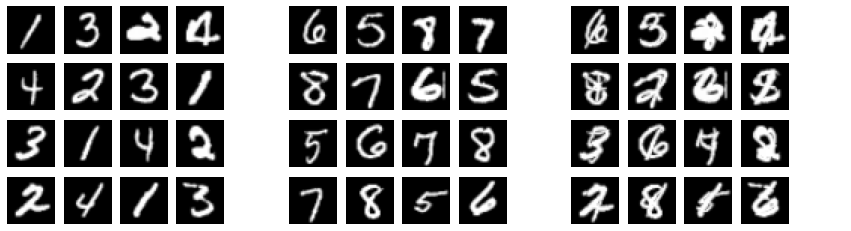

DRNets Separated Images


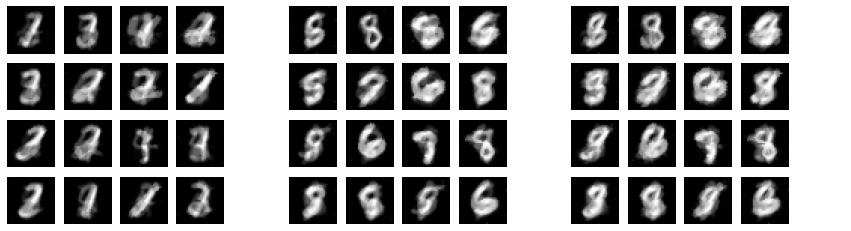

ground-truth labels
1,3,2,4, 6,5,8,7,
4,2,3,1, 8,7,6,5,
3,1,4,2, 5,6,7,8,
2,4,1,3, 7,8,5,6,
DRNets' predictions
1,3,4,2, 5,8,8,6,
3,2,2,1, 5,7,6,8,
3,3,3,4, 8,6,7,8,
2,1,1,3, 8,6,5,6,
Summary of epoch-0, #puzzle = 1000, sudoku_acc = 0.000000, label_acc = 0.160813, recon_loss = 0.267927
---------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
base1 = 1
base2 = 5 
n_data = sudoku.shape[0]
n_col = 4
n_row = 4
nums = 4
sep = resnet18(predictor=False)
pred = resnet18(predictor=True)
use_cuda = torch.cuda.is_available()

################################he hyper-parameters you may want to play with ########################
lr = 0.0001
optimizer_steps = 100
batch_size = 100
scale_recon = 0.001
keep_p = 1.0
entropy_cell_penalty = 0.01
entropy_alldiff_penalty = 1.0
start_reasoning_step = 0
#####################################################################################################

check_freq = n_data // batch_size

alldiff_constraints = gen_alldiff_constraints(nums, batch_size) #bs * 12 * 4
gen_labels = torch.LongTensor(np.arange(nums ** 3 * 2 * batch_size, dtype = "int32") % (2 * nums) + base1)

if use_cuda:
    sep = sep.cuda()
    pred = pred.cuda()
    gen_labels =  gen_labels.cuda()
    print("Using CUDA")

s_mix_lst = []
l1_lst = []
l2_lst = []
s1_lst = []
s2_lst = []


print ("Training Starts!")

#indices = np.arange(n_data)
#np.random.shuffle(indices)
for _epoch_ in range(optimizer_steps):
    all_sudoku_acc = 0
    all_label_acc = 0
    all_recon_loss = 0
    cnt = 0
    
    for idx in range(n_data):
    
        s1 = sudoku[idx]
        s2 = sudoku5678[idx]
        
        l1 = ori_label[idx]
        l2 = ori_label5678[idx]
        
        s1 = s1.reshape(nums, nums, 32, 32)
        s2 = s2.reshape(nums, nums, 32, 32)
        s_mix = np.maximum(s1, s2)
    
        s_mix = np.reshape(s_mix, (16, 1, 32, 32))
        
        #loading samples
        s_mix_lst.append(s_mix)
        l1_lst.append(l1)
        l2_lst.append(l2)
        s1_lst.append(s1)
        s2_lst.append(s2)
        
        if (len(s_mix_lst) == batch_size):
            s_mix = np.concatenate(s_mix_lst, axis = 0) # bs * 16, 1, 32, 32
            s_mix = Variable(torch.tensor(s_mix).float(), requires_grad=False)

            if use_cuda:
                s_mix = s_mix.cuda()
            
            epochs = 1
            for ii in range(epochs):
                
                labels1_distribution, labels2_distribution = pred(s_mix) #bs * 16, 4 

                if (use_cuda):
                    z = sep(torch.tensor(s_mix.reshape(-1, 1, 32, 32)).float()).cuda() #bs * 16, 2, 4, 100
                else:
                    z = sep(torch.tensor(s_mix.reshape(-1, 1, 32, 32)).float())

                optimizer = torch.optim.Adam(list(pred.parameters()) + list(sep.parameters()), lr=lr)
                
                # compute accs
                labels1 = labels1_distribution.cpu().data.numpy()
                labels2 = labels2_distribution.cpu().data.numpy()
                
                labels1_argmax = np.argmax(labels1, axis=1)
                labels2_argmax = np.argmax(labels2, axis=1)

                labels12 = np.concatenate([(labels1_argmax + base1).reshape(-1, 1), (labels2_argmax + base2).reshape(-1, 1)], axis = 1)
                
                l1 = np.concatenate(l1_lst, axis = 0)
                l2 = np.concatenate(l2_lst, axis = 0)
                
                l12 = np.concatenate([l1.reshape(-1, 1), l2.reshape(-1, 1)], axis = 1) # bs * 16, 2
                
                
                eqn = np.equal(labels12, l12).astype("int").reshape(batch_size, nums**2, 2)
                
                label_acc = np.mean((np.sum(eqn, axis = 2) == 2).astype("float32"))
                sudoku_acc = np.mean((np.sum(eqn, axis = (1,2)) == 32).astype("float32"))
                
                # compute mixture
                gen_imgs = generator(z.view(-1, 100), gen_labels) #bs*16*2*4, 1, 32, 32

                label_distribution = torch.cat([labels1_distribution, labels2_distribution], dim = 1) # bs * 16 * 8

                gen_mix = gen_imgs.permute(1, 2, 3, 0) * label_distribution.view(-1)

                gen_mix = gen_mix.view(1, 32, 32, batch_size * 16, 2, 4)

                gen_mix = torch.sum(gen_mix, dim = 5) # avg by distribution 1, 32, 32, bs*16, 2

                gen_img_demix = gen_mix.permute(3, 4, 0, 1, 2) # bs*16, 2, 32, 32 #only used for visualization

                gen_mix = torch.max(gen_mix, dim = 4)[0]

                gen_mix = gen_mix.permute(3, 0, 1, 2).view(-1, 32, 32) #bs * 16, 32, 32

                cri = torch.nn.L1Loss(reduction="sum")

                loss_recon = 0.

                loss_recon = cri(s_mix.view(-1, 32, 32), gen_mix)

                loss_recon /= (1.0 * labels1_distribution.size(0))
                
                #compute the entropy-based cardinality constraint losses 
                entropy_cell = 0.5 * (entropy(labels1_distribution) + entropy(labels2_distribution))
                
                #compute the entropy-based ALL-Diff constraint losses 
                all_diff_loss1 = entropy(torch.mean(labels1_distribution[torch.LongTensor(alldiff_constraints)], dim = 1))
                all_diff_loss2 = entropy(torch.mean(labels2_distribution[torch.LongTensor(alldiff_constraints)], dim = 1))
                entropy_alldiff = 0.5 * (all_diff_loss1 + all_diff_loss2) 

                drop_out_recon = torch.nn.Dropout(p = 1.0 - keep_p)
                drop_out_cell = torch.nn.Dropout(p = 1.0 - keep_p)
                drop_out_alldiff = torch.nn.Dropout(p = 1.0 - keep_p)

                loss_recon = drop_out_recon(loss_recon)
                entropy_cell_drop = drop_out_cell(entropy_cell)
                entropy_alldiff_drop = drop_out_alldiff(entropy_alldiff)

                if (_epoch_ < start_reasoning_step):
                    loss = scale_recon * loss_recon
                else:
                    loss = scale_recon * loss_recon +  entropy_cell_penalty * entropy_cell_drop - entropy_alldiff_penalty * (entropy_alldiff_drop)
            
                optimizer.zero_grad()
                loss.backward(retain_graph=True)
                optimizer.step()

                if (ii % 100 == 0 and (cnt + 1) % check_freq == 0):
                    
                    print ("epoch = %d, Iteration %d: total_loss: %f, loss_recon: %f, entropy_cell: %f, entropy_alldiff: %f\n" % \
                        (_epoch_, idx, loss.item(), scale_recon * loss_recon.item(), entropy_cell.item(),  entropy_alldiff.item()))
                    print ("Below is the visualization for the image, from left to right: 1. separate sudoku1 2. separate sudoku2 3. mixed sudoku")
                    print ("Ground-truth Images")
                    show_sudoku(s1_lst[0], s2_lst[0], np.reshape(s_mix_lst[0], (4, 4, 32, 32)), "s1")
                    
                    print ("DRNets Separated Images")
                    gen_imgs1_numpy = np.concatenate([item.cpu().data.numpy() for item in gen_img_demix[:nums**2,0]])
                    gen_imgs1_numpy = np.reshape(gen_imgs1_numpy, (4, 4, 32, 32))

                    gen_imgs2_numpy = np.concatenate([item.cpu().data.numpy() for item in gen_img_demix[:nums**2,1]])
                    gen_imgs2_numpy = np.reshape(gen_imgs2_numpy, (4, 4, 32, 32))

                    gen_mix_numpy = np.concatenate([item.cpu().data.numpy() for item in gen_mix[:nums**2]])
                    gen_mix_numpy = np.reshape(gen_mix_numpy, (4, 4, 32, 32))
                    
                    show_sudoku(gen_imgs1_numpy, gen_imgs2_numpy, gen_mix_numpy)
                    
                    print("ground-truth labels")
                    for i in range(4):
                        for j in range(4):
                            print(l1[i*4 + j], end = ",")
                        print(" ", end = "")

                        for j in range(4):
                            print(l2[i*4 + j], end = ",")
                        print("")
                        
                    print("DRNets' predictions")
                    for i in range(4):
                        for j in range(4):
                            print(labels1_argmax[i*4 + j] + base1, end = ",")
                        print(" ", end = "")

                        for j in range(4):
                            print(labels2_argmax[i*4 + j] + base2, end = ",")
                        print("")

            
            s_mix_lst = []
            l1_lst = []
            l2_lst = []
            s1_lst = []
            s2_lst = []
                 
            all_label_acc += label_acc
            all_sudoku_acc += sudoku_acc
            all_recon_loss += scale_recon * loss_recon.item()
            cnt += 1
        
            if (cnt % check_freq == 0):

                print("Summary of epoch-%d, #puzzle = %d, sudoku_acc = %f, label_acc = %f, recon_loss = %f"%(_epoch_, cnt * batch_size, all_sudoku_acc/cnt, all_label_acc/cnt, all_recon_loss/cnt))
                cnt = 0
                all_label_acc = 0
                all_sudoku_acc = 0
                all_recon_loss = 0
                print ("---------------------------------------------------------------------------------------------------------------------------------------")
                sys.stdout.flush()